# Post-stack seismic inversion of Marmousi model with IntraSeismic (with Monte Carlo Dropout)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pylops
from pylops.utils.wavelets import *
from intraseismic.utils import *
from intraseismic.dataset import *
from intraseismic.model import *
from intraseismic.train import *
from torchinfo import summary
import torch
import json
from matplotlib.colorbar import Colorbar
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

plt.rcParams['font.size'] = '9'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(42)

True

## Data Loading

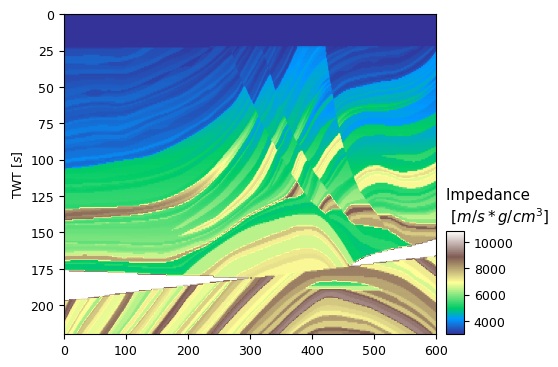

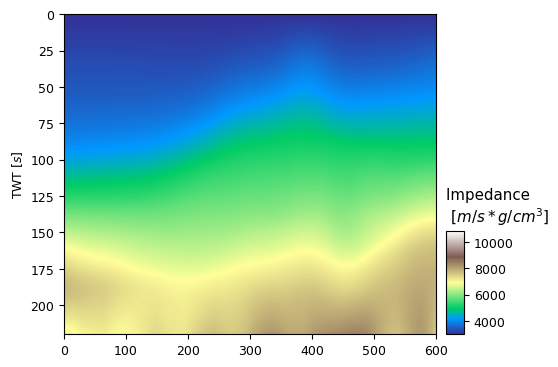

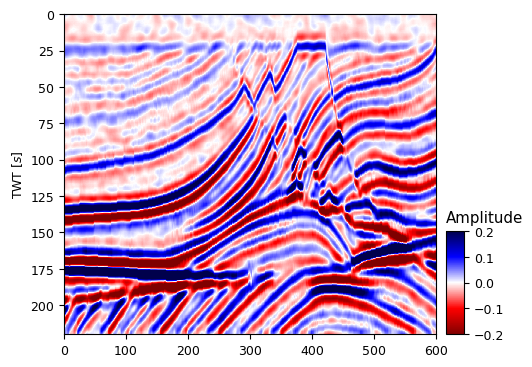

In [2]:
marm = np.load('../../data/Marmousi.npz')
d_tensor = torch.from_numpy(marm['dn1']).float().ravel() # noisy data
m_true = torch.from_numpy(marm['m_true'].astype('float32'))
mback = torch.from_numpy(np.log(marm['mback']).astype('float32')).float()
wav = marm['wav']

dims = mback.numpy().shape

vmin, vmax = np.percentile(marm['m_true'], [3, 97])
plotmodel(marm['m_true'], vmin, vmax)
plotmodel(marm['mback'], vmin, vmax)
plotdata(marm['dn1'])

## Data preparation

In [3]:
# General parameters
num_epochs = 1500
print_evry = 500
learning_rate = 1e-2

coords = create_coords(dims).to(device)
d =  d_tensor.to(device)
mback_ =  mback.ravel().to(device)

# Modeling Operator
G = pylops.avo.poststack.PoststackLinearModelling(wav/2, nt0=dims[0], spatdims=dims[1:])
G_torch = pylops.torchoperator.TorchOperator(G, device=device)

## IntraSeismic model setup

In [4]:
# IntraSeismic model setup
with open("config_marm.json") as f:
	config = json.load(f)
    
# IntraSeismic network 
net = create_model(n_input_dims=len(dims), n_output_dims=1, 
                   dropout=True, config=config).to(device)
summary(net)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Encoding: 1-1                          520,640
├─MLP_dropout: 1-2                       --
│    └─ModuleList: 2-1                   --
│    │    └─Linear: 3-1                  2,112
│    │    └─Linear: 3-2                  4,160
│    └─Linear: 2-2                       65
│    └─Dropout: 2-3                      --
Total params: 526,977
Trainable params: 526,977
Non-trainable params: 0

## Training

In [ ]:
net.

In [5]:
# Initialize optimizer and losses
combined_parameters = list(net.parameters())
optimizer = torch.optim.Adam(combined_parameters, lr=learning_rate)

# Training Loop
total_train_time = 0
epoch_losses = []
snrs = []

for epoch in range(1, num_epochs + 1):
    net.train()
    loss, epoch_time = train_is_sb(coords, d, mback_, dims, G_torch,
                                   net, optimizer,
                                   alpha_mtv = 1e-7,
                                   beta = 1e-4)
                                                                                       
    total_train_time += epoch_time
    epoch_losses.append(loss)
    net.eval()
    with torch.no_grad():
        delta_model = net(coords.to(device))
        model_ = delta_model.squeeze(1) + mback.ravel().to(device)
        snrs.append(SNR(m_true.ravel(), torch.exp(model_).cpu()))
    
    if epoch % print_evry == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss:.6f}, Training Time: {total_train_time:.2f}s')

print(f'Training completed in {total_train_time:.3f} seconds.')

Epoch [500/1500], Loss: 0.000594, Training Time: 2.48s
Epoch [1000/1500], Loss: 0.000576, Training Time: 4.23s
Epoch [1500/1500], Loss: 0.000571, Training Time: 5.99s
Training completed in 5.993 seconds.


Text(0.5, 1.0, 'SNR')

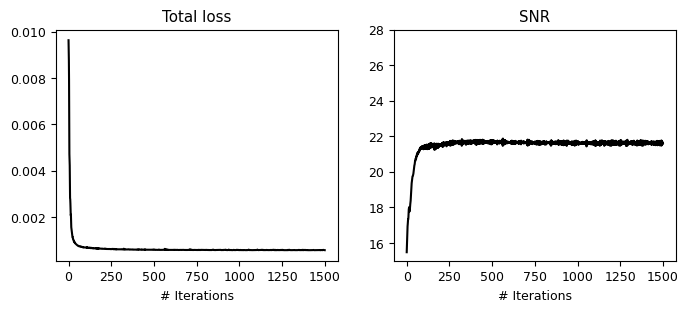

In [6]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(epoch_losses, 'k')
ax[0].set_xlabel('# Iterations')
# ax[0].set_ylim(0.0005, 0.0030)
ax[0].set_title('Total loss')
ax[1].plot(snrs, 'k')
ax[1].set_xlabel('# Iterations')
ax[1].set_ylim(15,28)
ax[1].set_title('SNR')

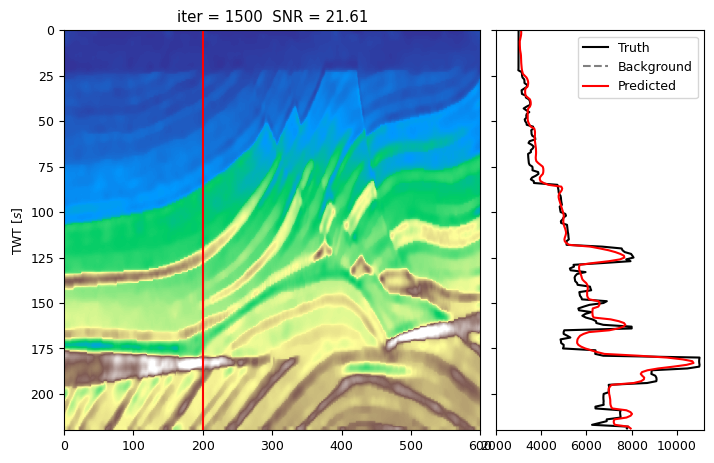

In [7]:
net.eval()
with torch.no_grad():
    delta_model = net(coords.to(device))
    model_ = delta_model.squeeze(1) + mback.ravel().to(device)

model_cpu= model_.reshape(*dims).detach().cpu()
plotresults(np.exp(model_cpu), np.exp(mback), vmin, vmax, 
            m_true=np.log(m_true), i=epoch)

In [8]:
def activate_dropout(model):
    """Activate dropout layers in the model."""
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

net.eval()
activate_dropout(net)

outputs = []
iter = 100
with torch.no_grad():
    for _ in range(iter):
        delta_model = net(coords.to(device))
        model_ = (delta_model.squeeze(1) + mback.ravel().to(device)).reshape(*dims)
        outputs.append(np.exp(model_.cpu().detach().numpy()))

mean = np.mean(np.array(outputs), axis=0)
std = np.std(np.array(outputs), axis=0)

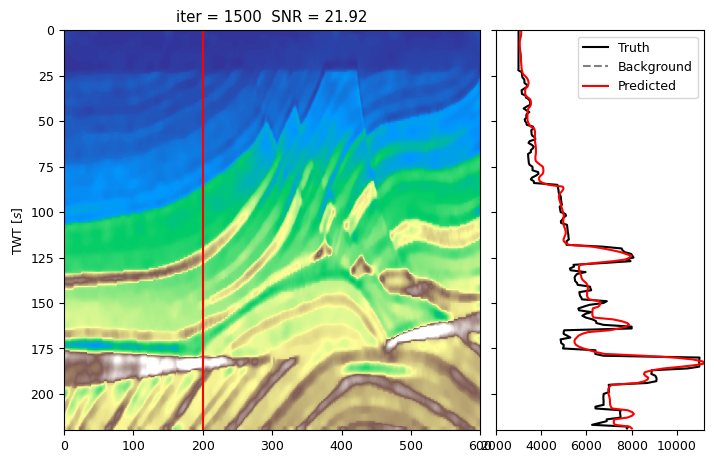

In [9]:
plotresults(mean, np.exp(mback), vmin, vmax, 
            m_true=np.log(m_true).numpy(),  i=epoch)

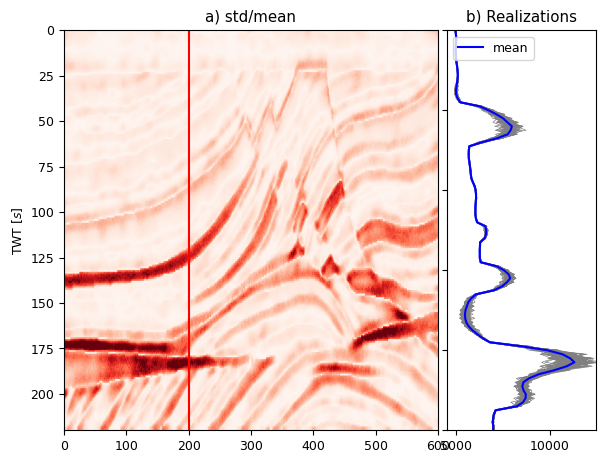

In [10]:
plotstd(std/mean, np.array(outputs), mean, np.exp(mback), 
        vmin=0, vmax=0.05, i=epoch, cmap='Reds')

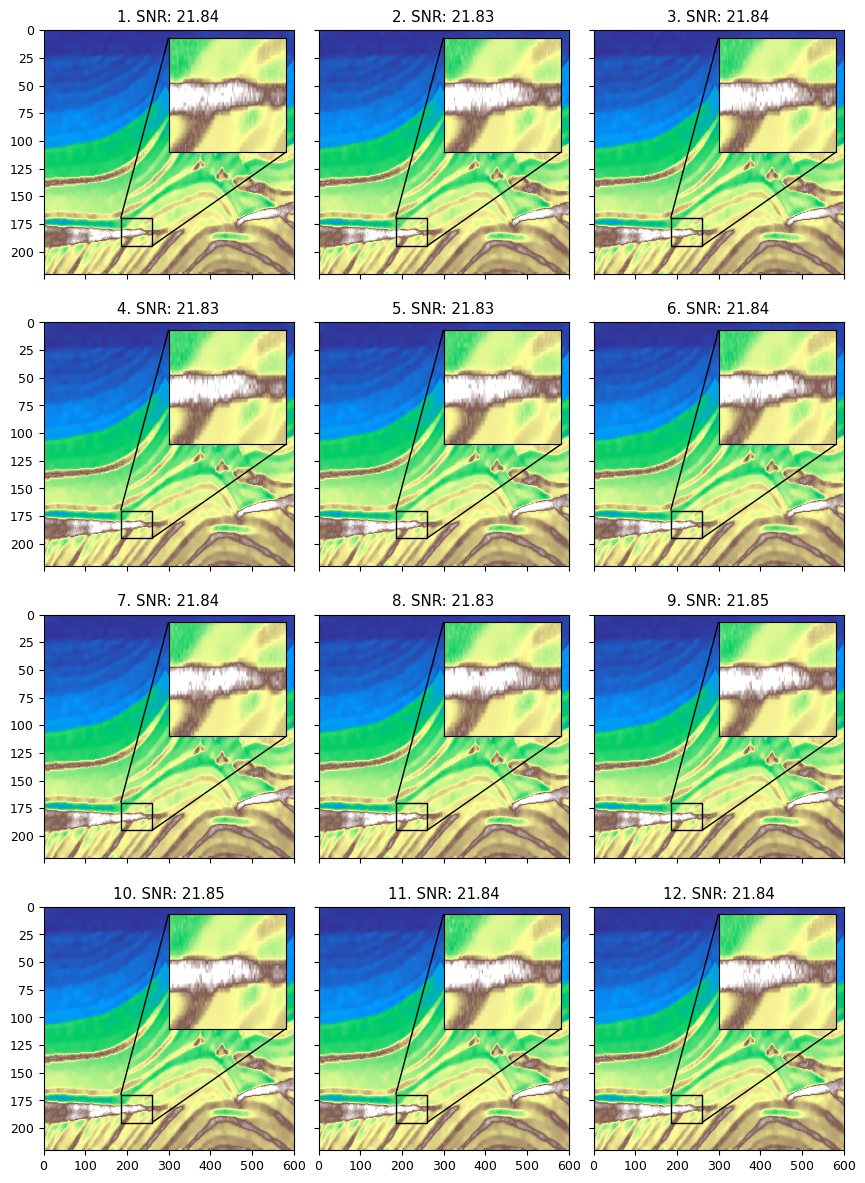

In [11]:
plt.rcParams['font.size'] = '9'
idx = np.random.randint(0,len(outputs),12)
cmap = 'terrain'
fig = plt.figure(figsize=(10, 14))
gs = gridspec.GridSpec(4, 3,
                       # width_ratios=[1, 1, 1, 1, 1], 
                       # height_ratios=(1),
                       left=0.1, right=0.9, bottom=0.1, top=0.9,
                       wspace=0.1, hspace=0.2)
ax0 = fig.add_subplot(gs[0,0])
ax0.tick_params(axis="x", labelbottom=False)
ax1 = fig.add_subplot(gs[0,1])
ax1.tick_params(axis="x", labelbottom=False)
ax1.tick_params(axis="y", labelleft=False)
ax2 = fig.add_subplot(gs[0,2], sharey=ax0)
ax2.tick_params(axis="x", labelbottom=False)
ax2.tick_params(axis="y", labelleft=False)
ax3 = fig.add_subplot(gs[1,0])
ax3.tick_params(axis="x", labelbottom=False)
ax4 = fig.add_subplot(gs[1,1])
ax4.tick_params(axis="x", labelbottom=False)
ax4.tick_params(axis="y", labelleft=False)
ax5 = fig.add_subplot(gs[1,2])
ax5.tick_params(axis="x", labelbottom=False)
ax5.tick_params(axis="y", labelleft=False)
ax6 = fig.add_subplot(gs[2,0])
ax6.tick_params(axis="x", labelbottom=False)
ax7 = fig.add_subplot(gs[2,1])
ax7.tick_params(axis="x", labelbottom=False)
ax7.tick_params(axis="y", labelleft=False)
ax8 = fig.add_subplot(gs[2,2])
ax8.tick_params(axis="x", labelbottom=False)
ax8.tick_params(axis="y", labelleft=False)
ax9 = fig.add_subplot(gs[3,0])
ax10 = fig.add_subplot(gs[3,1])
ax10.tick_params(axis="y", labelleft=False)
ax11 = fig.add_subplot(gs[3,2])
ax11.tick_params(axis="y", labelleft=False)
extent = (0, outputs[idx[0]].shape[1], outputs[idx[0]].shape[0], 0)
extent_zoom = (185, 260, 170, 195)
for i, j in zip(np.arange(12), [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11]):
    j.imshow(outputs[idx[i]], vmin=vmin, vmax=vmax, cmap=cmap, extent=extent)
    j.set_title(f'{i+1}. SNR: {SNR(outputs[idx[i]], m_true.numpy()):.2f}')
    j.axis('tight');
    axins = j.inset_axes([0.5, 0.5, 0.47, 0.47])
    axins.imshow(outputs[idx[i]], vmin=vmin, vmax=vmax, cmap="terrain", extent=extent)
    axins.axis('tight')
    x1, x2, y1, y2 =  extent_zoom
    axins.set_xlim(x1, x2)
    axins.set_ylim(y2, y1)
    axins.set_xticks([])
    axins.set_yticks([])
    _patch, pp1, pp2 = mark_inset(j, axins, loc1=1, loc2=3, fc="none", ec="black")
    pp1.loc1, pp1.loc2 = 4, 1
    pp2.loc1, pp2.loc2 = 2, 3
    
# plt.savefig('../plots/marm_uq_realizations',  bbox_inches='tight', transparent=True)

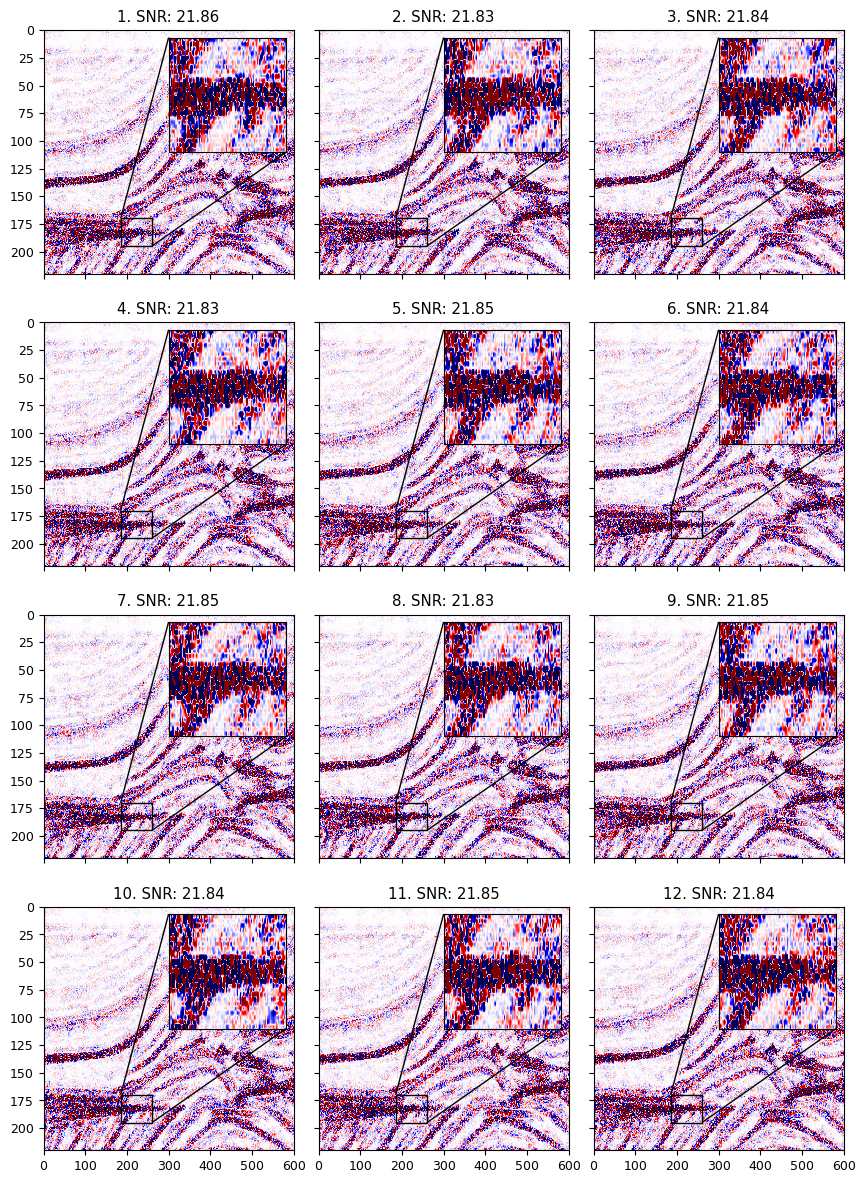

In [12]:
plt.rcParams['font.size'] = '9'
idx = np.random.randint(0,len(outputs),12)
cmap = 'seismic_r'
fig = plt.figure(figsize=(10, 14))
gs = gridspec.GridSpec(4, 3,
                       # width_ratios=[1, 1, 1, 1, 1], 
                       # height_ratios=(1),
                       left=0.1, right=0.9, bottom=0.1, top=0.9,
                       wspace=0.1, hspace=0.2)
ax0 = fig.add_subplot(gs[0,0])
ax0.tick_params(axis="x", labelbottom=False)
ax1 = fig.add_subplot(gs[0,1])
ax1.tick_params(axis="x", labelbottom=False)
ax1.tick_params(axis="y", labelleft=False)
ax2 = fig.add_subplot(gs[0,2], sharey=ax0)
ax2.tick_params(axis="x", labelbottom=False)
ax2.tick_params(axis="y", labelleft=False)
ax3 = fig.add_subplot(gs[1,0])
ax3.tick_params(axis="x", labelbottom=False)
ax4 = fig.add_subplot(gs[1,1])
ax4.tick_params(axis="x", labelbottom=False)
ax4.tick_params(axis="y", labelleft=False)
ax5 = fig.add_subplot(gs[1,2])
ax5.tick_params(axis="x", labelbottom=False)
ax5.tick_params(axis="y", labelleft=False)
ax6 = fig.add_subplot(gs[2,0])
ax6.tick_params(axis="x", labelbottom=False)
ax7 = fig.add_subplot(gs[2,1])
ax7.tick_params(axis="x", labelbottom=False)
ax7.tick_params(axis="y", labelleft=False)
ax8 = fig.add_subplot(gs[2,2])
ax8.tick_params(axis="x", labelbottom=False)
ax8.tick_params(axis="y", labelleft=False)
ax9 = fig.add_subplot(gs[3,0])
ax10 = fig.add_subplot(gs[3,1])
ax10.tick_params(axis="y", labelleft=False)
ax11 = fig.add_subplot(gs[3,2])
ax11.tick_params(axis="y", labelleft=False)
extent = (0, outputs[idx[0]].shape[1], outputs[idx[0]].shape[0], 0)
extent_zoom = (185, 260, 170, 195)
for i, j in zip(np.arange(12), [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11]):
    j.imshow(outputs[idx[i]] - mean, vmin=-1e2, vmax=1e2, cmap=cmap, extent=extent)
    j.set_title(f'{i+1}. SNR: {SNR(outputs[idx[i]], m_true.numpy()):.2f}')
    j.axis('tight');
    axins = j.inset_axes([0.5, 0.5, 0.47, 0.47])
    axins.imshow(outputs[idx[i]]-mean, vmin=-1e2, vmax=1e2, cmap=cmap, extent=extent)
    axins.axis('tight')
    x1, x2, y1, y2 =  extent_zoom
    axins.set_xlim(x1, x2)
    axins.set_ylim(y2, y1)
    axins.set_xticks([])
    axins.set_yticks([])
    _patch, pp1, pp2 = mark_inset(j, axins, loc1=1, loc2=3, fc="none", ec="black")
    pp1.loc1, pp1.loc2 = 4, 1
    pp2.loc1, pp2.loc2 = 2, 3
    
# plt.savefig('../plots/marm_uq_realizations',  bbox_inches='tight', transparent=True)